### run this notebook for each patient following Plastimatch DIR and calculation of the Jacobian determinant

In [1]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage
from os.path import expanduser
import glob
from matplotlib.ticker import MaxNLocator
from scipy.stats import spearmanr
import seg_metrics.seg_metrics as sg
import pickle
import matplotlib.patches as mpatches
from skimage import exposure
from scipy import ndimage
import nibabel as nib

In [2]:
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("SITK version:", sitk.__version__)
print("Scikit-image version:", skimage.__version__)

Python version: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Numpy version: 1.26.2
Matplotlib version: 3.8.2
SITK version: 2.3.1
Scikit-image version: 0.22.0


In [3]:
patient_id = 1

In [4]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
PREPROCESSED_MHA_DIR = '{}/mha/Patient{:02d}'.format(PREPROCESSED_BASE_DIR, patient_id)
PREPROCESSED_STACK_DIR = '{}/stack'.format(PREPROCESSED_BASE_DIR)

#### load the Jacobian determinant and calculate the CTVI-Jac

In [5]:
# load images from the Plastimatch (pm) processing
pm_exhale_im = sitk.ReadImage('{}/phase-exhale-nomask.mha'.format(PREPROCESSED_MHA_DIR))
pm_inhale_im = sitk.ReadImage('{}/phase-inhale-nomask.mha'.format(PREPROCESSED_MHA_DIR))
pm_mask_im = sitk.ReadImage('{}/mask-union.mha'.format(PREPROCESSED_MHA_DIR))

pm_exhale_arr = sitk.GetArrayFromImage(pm_exhale_im)
pm_inhale_arr = sitk.GetArrayFromImage(pm_inhale_im)
pm_mask_arr = sitk.GetArrayFromImage(pm_mask_im).astype(bool)

jacobian_det_im = sitk.ReadImage('{}/vf_jac.mha'.format(PREPROCESSED_MHA_DIR))
jacobian_det_arr = sitk.GetArrayFromImage(jacobian_det_im)

/home/daryl/miniconda3/envs/py310/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
jacobian_det_arr.shape

(167, 512, 512)

In [7]:
prop = np.sum(np.array(jacobian_det_arr[pm_mask_arr]) < 0) / len(jacobian_det_arr[pm_mask_arr].ravel())
print('proportion of voxels with negative values in Jacobian determinant = {}'.format(round(prop, 2)))

proportion of voxels with negative values in Jacobian determinant = 0.0


In [8]:
ctvi_jac_arr = jacobian_det_arr-1.0
ctvi_jac_arr[~pm_mask_arr] = np.min(ctvi_jac_arr)
ctvi_jac_im = sitk.GetImageFromArray(ctvi_jac_arr)

# set the spacing and origin in the CTVI-Jac image
ctvi_jac_im.SetSpacing(jacobian_det_im.GetSpacing())
ctvi_jac_im.SetOrigin(jacobian_det_im.GetOrigin())

In [9]:
ctvi_jac_im.GetSize(), ctvi_jac_im.GetSpacing(), ctvi_jac_im.GetOrigin()

((512, 512, 167),
 (0.9765625, 0.9765625, 1.7999999523162842),
 (-249.51171875, -400.01171875, -75.0))

#### resample, crop, & pad the CTVI-Jac so we can make a comparison with model predictions

In [10]:
# Resampling the images into (1,1,1)mm voxel size. Can use nearest neighbour for interpolation (default is B-spline). 
def resample_image(itk_image, out_spacing=(1.0, 1.0, 1.0), is_label=False):
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [11]:
ctvi_jac_im = resample_image(ctvi_jac_im)

In [12]:
# convert back into numpy array after resampling
ctvi_jac_arr= sitk.GetArrayFromImage(ctvi_jac_im)

In [13]:
ctvi_jac_arr.shape

(301, 500, 500)

In [14]:
TARGET_SIZE_X = 320
TARGET_SIZE_Y = 320
TARGET_SIZE_Z = 300

In [15]:
# pad z axis if needed
if ctvi_jac_arr.shape[0] < TARGET_SIZE_Z:
    pad_slices = TARGET_SIZE_Z - ctvi_jac_arr.shape[0]
    ctvi_jac_arr = np.pad(ctvi_jac_arr, pad_width=((0,pad_slices),(0,0),(0,0)), mode='constant', constant_values=np.min(ctvi_jac_arr))  # pad at the back

# crop x and y axes of CT
crop_x_lower = int(np.round((ctvi_jac_arr.shape[2]-TARGET_SIZE_X)/2)); crop_x_upper = crop_x_lower+TARGET_SIZE_X
crop_y_lower = int(np.round((ctvi_jac_arr.shape[1]-TARGET_SIZE_Y)/2)); crop_y_upper = crop_y_lower+TARGET_SIZE_Y
crop_z_lower = int(np.round((ctvi_jac_arr.shape[0]-TARGET_SIZE_Z)/2)); crop_z_upper = crop_z_lower+TARGET_SIZE_Z

ctvi_jac_arr = ctvi_jac_arr[crop_z_lower:crop_z_upper, crop_y_lower:crop_y_upper, crop_x_lower:crop_x_upper]

ctvi_jac_arr.shape

(300, 320, 320)

#### normalise the CTVI-Jac

In [16]:
ctvi_jac_arr = exposure.rescale_intensity(ctvi_jac_arr, in_range='image', out_range=(1e-3,1.))

#### apply a median filter

In [17]:
ctvi_jac_arr = ndimage.median_filter(ctvi_jac_arr, size=7)

#### load the PET ground truth (unquantised and quantised)

In [18]:
output_name = '{}/Patient{:02d}.npy'.format(PREPROCESSED_STACK_DIR, patient_id)
pt_arr = np.load(output_name)
print('loaded stack from {}'.format(output_name))

exp_arr = pt_arr[0]
insp_arr = pt_arr[1]
pet_arr = pt_arr[2]
pet_labels_arr = pt_arr[3]
mask_arr = pt_arr[4].astype(bool)

loaded stack from /mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch/stack/Patient01.npy


In [19]:
pet_labels_arr.shape, mask_arr.shape

((300, 320, 320), (300, 320, 320))

### compare unquantised CTVI-Jac with PET ground truth

In [20]:
DISPLAY_IDX = 150

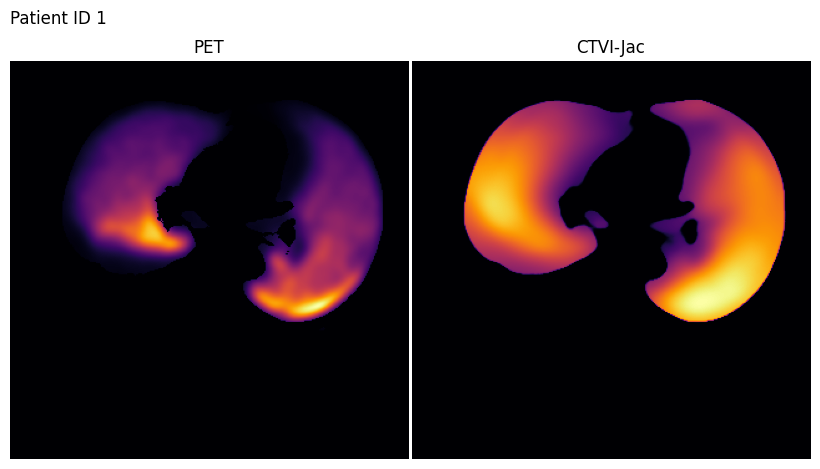

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(pet_arr[DISPLAY_IDX], cmap="inferno")
# ax1.imshow(ctvi_jac_arr[DISPLAY_IDX], cmap="Greys", alpha=0.6)
ax1.set_title('PET')
ax1.set_axis_off()

ax2.imshow(ctvi_jac_arr[DISPLAY_IDX], cmap="inferno")
ax2.set_title('CTVI-Jac')
ax2.set_axis_off()

fig.suptitle('Patient ID {}'.format(patient_id), x=0.1, y=0.75, fontsize=12, ha='left')

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

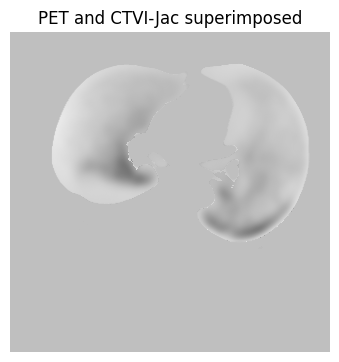

In [22]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15,4))
ax1.imshow(ctvi_jac_arr[DISPLAY_IDX], cmap="gist_gray", alpha=0.5)
ax1.imshow(pet_arr[DISPLAY_IDX], cmap="gist_yarg", alpha=0.5)
ax1.set_title('PET and CTVI-Jac superimposed')
ax1.set_axis_off()

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

In [23]:
sp = spearmanr(pet_arr[mask_arr], ctvi_jac_arr[mask_arr])
print('Spearman: {}'.format(np.round(sp[0],2)))
patient_eval_d = {'spearman_correlation':sp[0]}

Spearman: 0.7


In [24]:
PREPROCESSED_BASE_DIR = '/mnt/data/datasets/RNSH_HFlung/pre-processed-plastimatch'
EVALUATION_DIR = '{}/evaluation'.format(PREPROCESSED_BASE_DIR)
PATIENT_EVALUATION_DIR = '{}/Patient{:02d}'.format(EVALUATION_DIR, patient_id)

In [25]:
if not os.path.exists(EVALUATION_DIR):
    os.makedirs(EVALUATION_DIR)

if not os.path.exists(PATIENT_EVALUATION_DIR):
    os.makedirs(PATIENT_EVALUATION_DIR)

In [26]:
DATASET_EVALUATION_FILE = '{}/evaluation-unquantised.pkl'.format(EVALUATION_DIR)

if os.path.isfile(DATASET_EVALUATION_FILE):
    with open(DATASET_EVALUATION_FILE, 'rb') as f:
        dataset_d = pickle.load(f)
else:
    dataset_d = {}

dataset_d[patient_id] = patient_eval_d

with open(DATASET_EVALUATION_FILE, 'wb') as f:
        pickle.dump(dataset_d, f)

In [27]:
print('{: >10}{: >12}'.format('Patient ID','Spearman'))
for k,v in dataset_d.items():
    print('{: >10}{: >12.2f}'.format(k, v['spearman_correlation']))

Patient ID    Spearman
         1        0.70


In [28]:
spearman = []
spearman.append([value['spearman_correlation'] for key, value in dataset_d.items()])

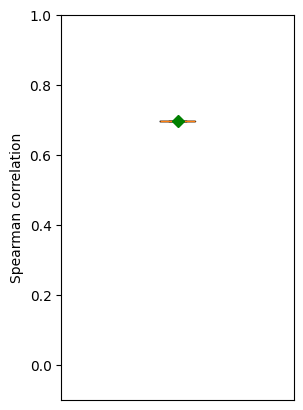

In [29]:
f, ax1 = plt.subplots()
f.set_figheight(5)
f.set_figwidth(3)

plt.margins(0.06)

red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='lightgrey')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

bp = ax1.boxplot(spearman, showfliers=True, showmeans=True, meanprops=mean_shape, flierprops=red_circle)

# ax1.set_xticklabels(['high', 'medium', 'low'])
# plt.xlabel('lung function')
ax1.set_xticks([])
plt.ylabel('Spearman correlation')
ax1.set_ylim([-0.1, 1])
plt.show()

### compare quantised CTVI-Jac with PET ground truth

#### quantise the CTVI-Jac

In [30]:
percentile_high = np.percentile(ctvi_jac_arr[mask_arr],70)
percentile_medium = np.percentile(ctvi_jac_arr[mask_arr],30)

In [31]:
percentile_high,percentile_medium

(0.6694318413734436, 0.4966710269451141)

In [32]:
high_func_idxs = (ctvi_jac_arr>percentile_high)
med_func_idxs = (ctvi_jac_arr<=percentile_high) & (ctvi_jac_arr>=percentile_medium)
low_func_idxs = (ctvi_jac_arr<percentile_medium) & (ctvi_jac_arr>np.min(ctvi_jac_arr))

ctvi_jac_label_arr = np.full_like(ctvi_jac_arr, 0)
ctvi_jac_label_arr[high_func_idxs] = 1
ctvi_jac_label_arr[med_func_idxs] = 2
ctvi_jac_label_arr[low_func_idxs] = 3
ctvi_jac_label_arr[~mask_arr] = 0

#### visualise the images

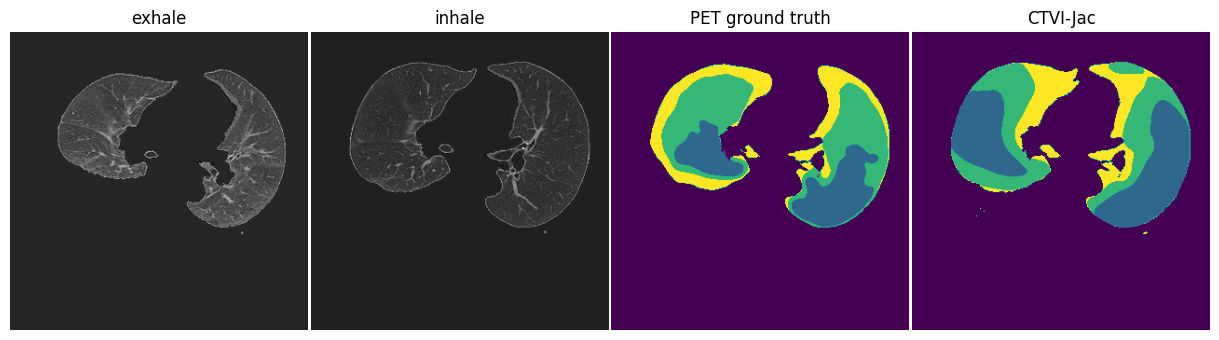

In [33]:
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15,4))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4))
ax1.imshow(exp_arr[DISPLAY_IDX], cmap="gray")
ax1.set_title('exhale')
ax1.set_axis_off()

ax2.imshow(insp_arr[DISPLAY_IDX], cmap="gray")
ax2.set_title('inhale')
ax2.set_axis_off()

ax3.imshow(pet_labels_arr[DISPLAY_IDX])
ax3.set_title('PET ground truth')
ax3.set_axis_off()

ax4.imshow(ctvi_jac_label_arr[DISPLAY_IDX])
ax4.set_title('CTVI-Jac')
ax4.set_axis_off()

fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.01, 
                    hspace=0.1)

#### write out the quantised CTVI-Jac for comparison

In [34]:
sitk.WriteImage(sitk.GetImageFromArray(ctvi_jac_label_arr), '{}/ctvi-jac-label.mha'.format(PREPROCESSED_MHA_DIR))